**essential libraries for docs handling**

In [1]:
import sklearn
import numpy as np
import re
import string
import pandas as pd
import nltk
import re
import os
import sys
import codecs


**libararies for plotting and Splitting and removing the extras from files**

In [2]:
from sklearn import feature_extraction
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from datetime import datetime
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics.pairwise import cosine_similarity
import joblib
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics.pairwise import euclidean_distances

**Downloading nltk for Stopwards and punctuation**

In [3]:
stemmer = SnowballStemmer("english")
nltk.download('stopwords')
nltk.download('punkt')

print("Start date and time =", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))# dd/mm/YY H:M:S

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Start date and time = 04/01/2021 20:04:02


**Function for Tokenize and stemming**

In [4]:
def tokenize_and_stem(text):
    #Clean Headers
    text = re.sub(r'(From:\s+[^\n]+\n)', '', text)
    text = re.sub(r'(Subject:[^\n]+\n)', '', text)
    text = re.sub(r'(([\sA-Za-z0-9\-]+)?[A|a]rchive-name:[^\n]+\n)', '', text)
    text = re.sub(r'(Last-modified:[^\n]+\n)', '', text)
    text = re.sub(r'(Version:[^\n]+\n)', '', text)
    #Clean More Text
    text = text.lower()
    text = text.strip()
    re_url = re.compile(r'(?:http|ftp|https)://(?:[\w_-]+(?:(?:\.[\w_-]+)+))(?:[\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
    re_email = re.compile('(?:[a-z0-9!#$%&\'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&\'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])')
    text = re.sub(re_url, '', text)
    text = re.sub(re_email, '', text)
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    text = re.sub(r'(\d+)', ' ', text)
    text = re.sub(r'(\s+)', ' ', text)
    # Remove repeating chars
    text = re . sub (r"!+", "! ", text )
    text = re . sub (r" \.+ ", ". ", text )
    text = re . sub (r" \?+ ", "? ", text )
    text = re . sub (r" \*+ ", "* ", text )
    text = re . sub (r"\ >+", "> ", text )
    text = re . sub (r"\ <+", "< ", text )
    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


**SPlitting the dataset into train test**

In [5]:
def splite_data(data,target,size):
    X_train, X_test, y_train, y_test = train_test_split(data,target,random_state=42, test_size=size)
    print((1-size)*100,'%-------------',size*100,'%')
    print ('Train set:', len(X_train), len(y_train))
    print ('Test set:', len(X_test), len(y_test))
    return X_train, X_test, y_train, y_test

**Accessing Documents from URL**

In [6]:
dataset=fetch_20newsgroups(subset='all',shuffle=True,random_state=42)
print("date and time =", datetime.now().strftime("%d/%m/%Y %H:%M:%S"))# dd/mm/YY H:M:S

X_train_80, X_test_20, y_train_80, y_test_20=splite_data(dataset.data,dataset.target,0.20)
X_train_70, X_test_30, y_train_70, y_test_30=splite_data(dataset.data,dataset.target,0.30)
X_train_60, X_test_40, y_train_60, y_test_40=splite_data(dataset.data,dataset.target,0.40)

date and time = 04/01/2021 20:04:13
80.0 %------------- 20.0 %
Train set: 15076 15076
Test set: 3770 3770
70.0 %------------- 30.0 %
Train set: 13192 13192
Test set: 5654 5654
60.0 %------------- 40.0 %
Train set: 11307 11307
Test set: 7539 7539


**Function of Optimal Cluster for elbow finding**

In [7]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')

**For k-means clustering visualization**

In [8]:
def KMeans_cluster_visualization(PCA,clusters,group,dataset,test_type):
    
    print("Cluster Type",test_type)
    #create data frame that has the result of the MDS plus the cluster numbers and titles
    #df = pd.DataFrame(dict(x=X_pca[:,0], y=X_pca[:, 1], z=X_pca[:, 2], cluster=clusters,news_group=y_train, title=[dataset.target_names[i] for i in y_train])) 
    df = pd.DataFrame(dict(x=PCA[:,0], y=PCA[:, 1], z=PCA[:, 2], cluster=clusters,news_group=group, title=[dataset.target_names[i] for i in group])) 
    #group by cluster
    groups = df.groupby('cluster')
    # For Lable Checking For Give Cluster
    df2 = df.groupby(['cluster', 'news_group'])['news_group'].size()
    df2 = df2.reset_index(level='cluster').groupby('cluster')['news_group'].idxmax().reset_index(name='news_group')
    news_groups=['alt.atheism',
         'comp.graphics',
         'comp.os.ms-windows.misc',
         'comp.sys.ibm.pc.hardware',
         'comp.sys.mac.hardware',
         'comp.windows.x',
         'misc.forsale',
         'rec.autos',
         'rec.motorcycles',
         'rec.sport.baseball',
         'rec.sport.hockey',
         'sci.crypt',
         'sci.electronics',
         'sci.med',
         'sci.space',
         'soc.religion.christian',
         'talk.politics.guns',
         'talk.politics.mideast',
         'talk.politics.misc',
         'talk.religion.misc']
    
    # set up plot
    fig = plt.figure(figsize=(17, 9))
    ax = fig.add_subplot(111, projection='3d')
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    for name, group in groups:
        ax.plot(group.x, group.y, group.z, marker='o', linestyle='', ms=10, label=news_groups[pd.to_numeric(df2.loc[df2['cluster'] == name, 'news_group'].iloc[0])], mec='none')
        ax.set_aspect('auto')
        ax.tick_params(\
            axis= 'x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off')
        ax.tick_params(\
            axis= 'y',         # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelleft='off')

    ax.legend(numpoints=1)  #show legend with only 1 point   
  

    plt.show() #show the plot
    plt.close()

**For split Adjustment**

In [9]:
def KMeans_cluster(X_train, X_test, y_train, y_test,num_clusters,dataset):
    
    #Train
    tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=8000,
                                 min_df=1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem)
    
    tfidf = tfidf_vectorizer.fit_transform(X_train)

    kmeans = KMeans(n_clusters=num_clusters ,init='k-means++',max_iter=100, n_init=1 ).fit(tfidf)
    clusters = kmeans.labels_.tolist()
    
    pca = PCA(n_components = 3).fit(tfidf.toarray())
    X_pca = pca.transform(tfidf.toarray())
    
    KMeans_cluster_visualization(X_pca,clusters,y_train,dataset,'Train'+' & clusters ('+str(num_clusters)+')' )   
   
    tfidf2 = tfidf_vectorizer.transform(X_test)

    Y=kmeans.predict(tfidf2)
    
    pca = PCA(n_components = 3).fit(tfidf2.toarray())
    X_pca = pca.transform(tfidf2.toarray())
    
    KMeans_cluster_visualization(X_pca,Y,y_test,dataset,'Test'+' & clusters ('+str(num_clusters)+')' )
    
    #InterCluster Distance  ('Distance Between Clusters')
    distances = euclidean_distances(kmeans.cluster_centers_)
    tri_dists = distances[np.triu_indices(num_clusters, 1)]
    print( "Complete Linkage Distance",tri_dists.max())
    print( "Average Linkage Distance", tri_dists.mean())
    print( "Single Linkage Distance", tri_dists.min())

# PLotting all the cluster

**for 80-20 splitting|**
**for 70-30 splitting|**
**for 60-40 splitting**

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (3)


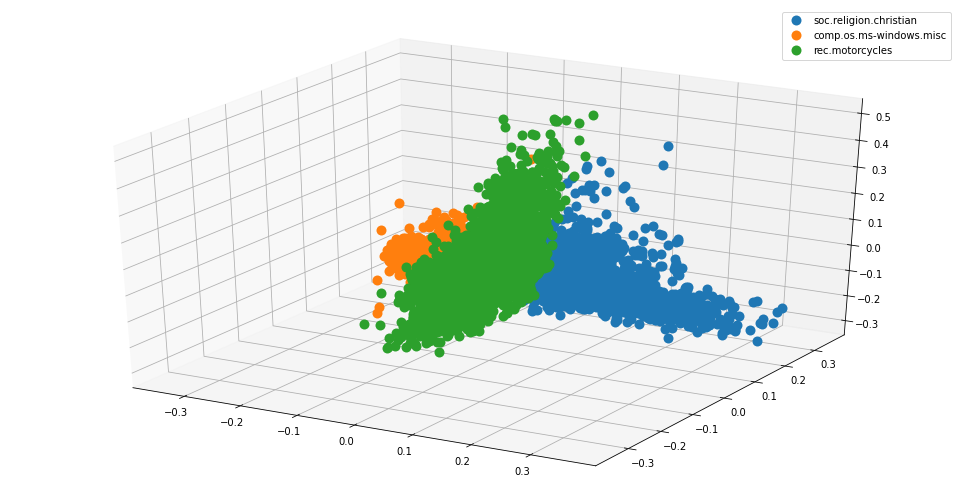

Cluster Type Test & clusters (3)


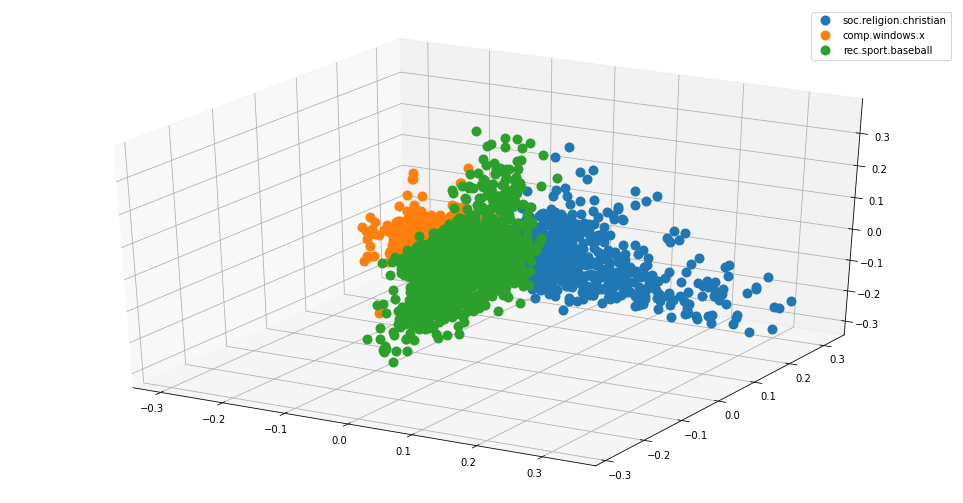

Complete Linkage Distance 0.22613376189501824
Average Linkage Distance 0.178245086585644
Single Linkage Distance 0.14970772725636458


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (6)


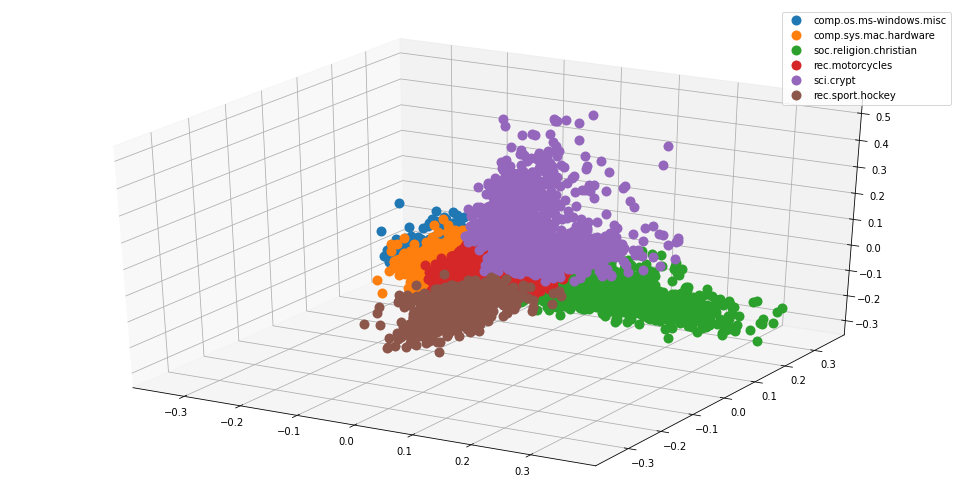

Cluster Type Test & clusters (6)


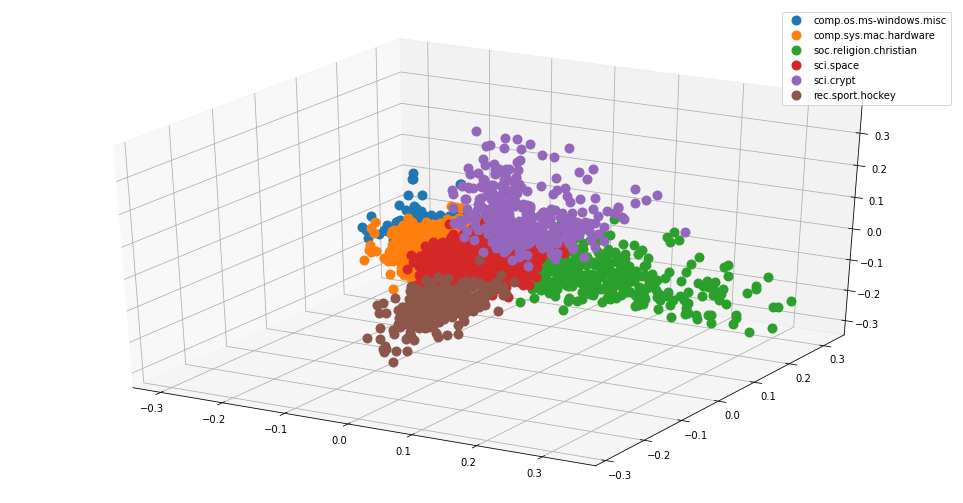

Complete Linkage Distance 0.2986821615930061
Average Linkage Distance 0.22761702790833926
Single Linkage Distance 0.11633530154450912


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (12)


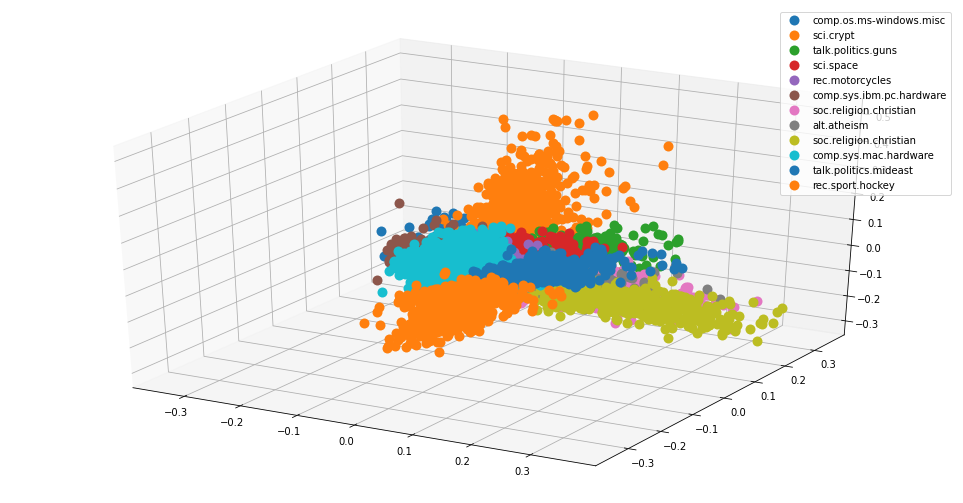

Cluster Type Test & clusters (12)


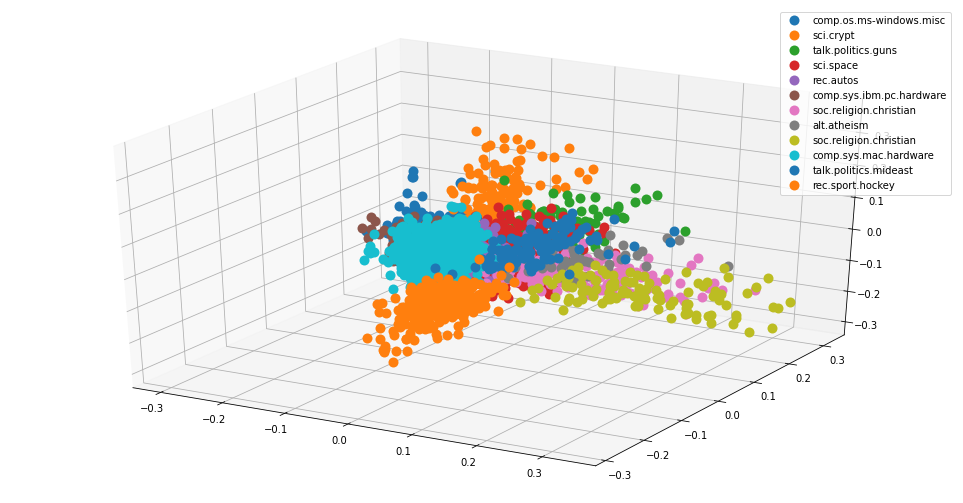

Complete Linkage Distance 0.4585291884414497
Average Linkage Distance 0.3167215252246899
Single Linkage Distance 0.1160339696876013


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (20)


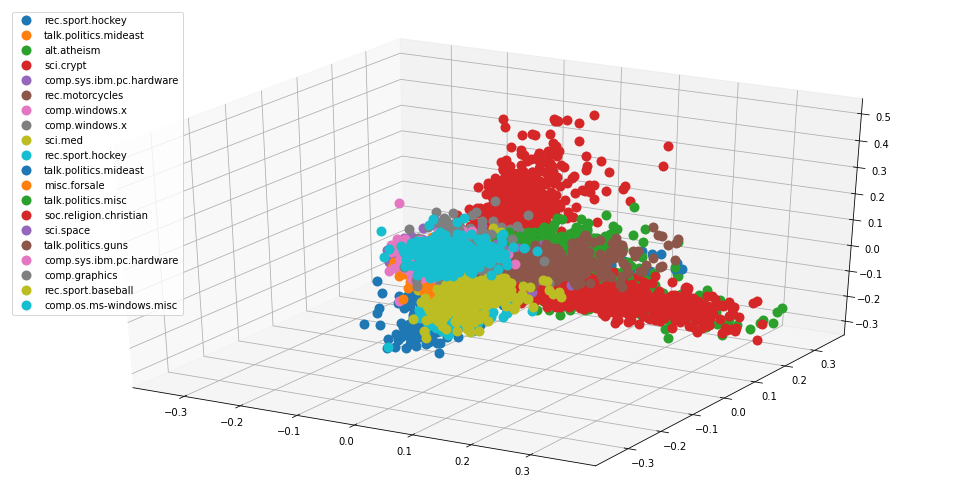

Cluster Type Test & clusters (20)


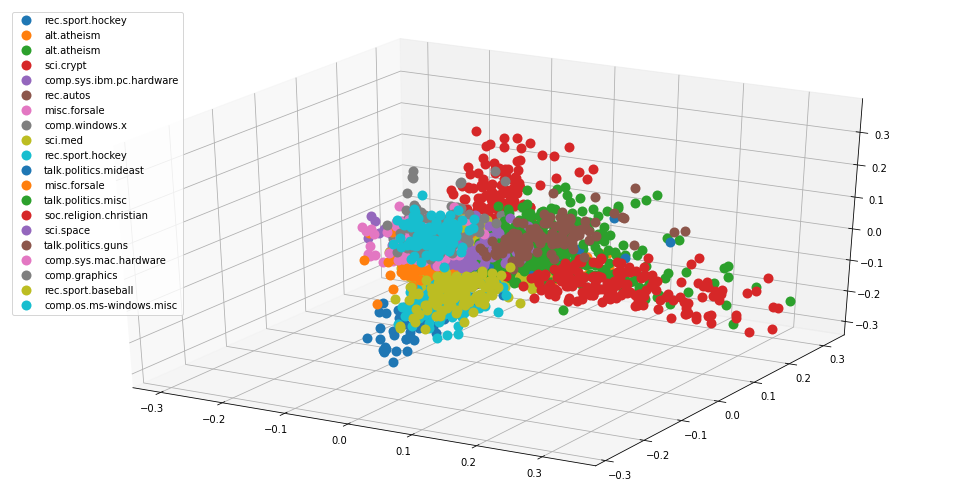

Complete Linkage Distance 0.5516877671770445
Average Linkage Distance 0.3583379298189138
Single Linkage Distance 0.1428439556959017


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (3)


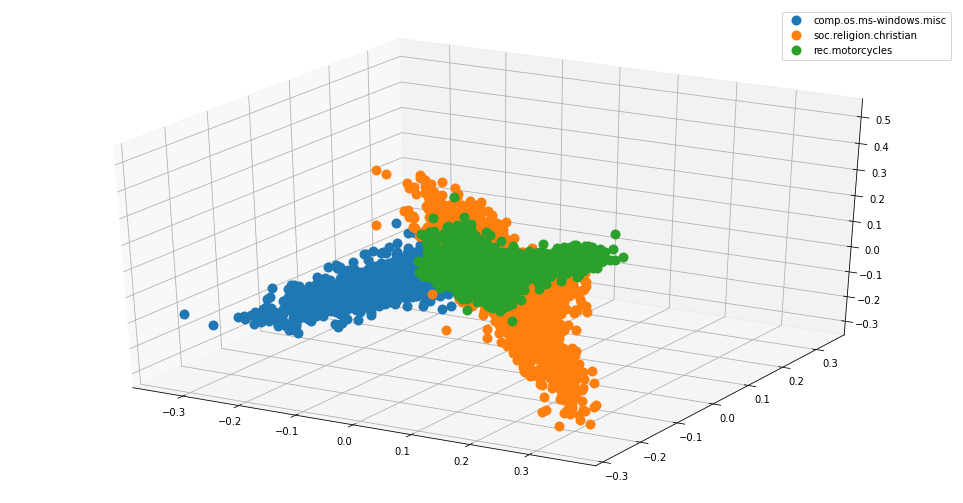

Cluster Type Test & clusters (3)


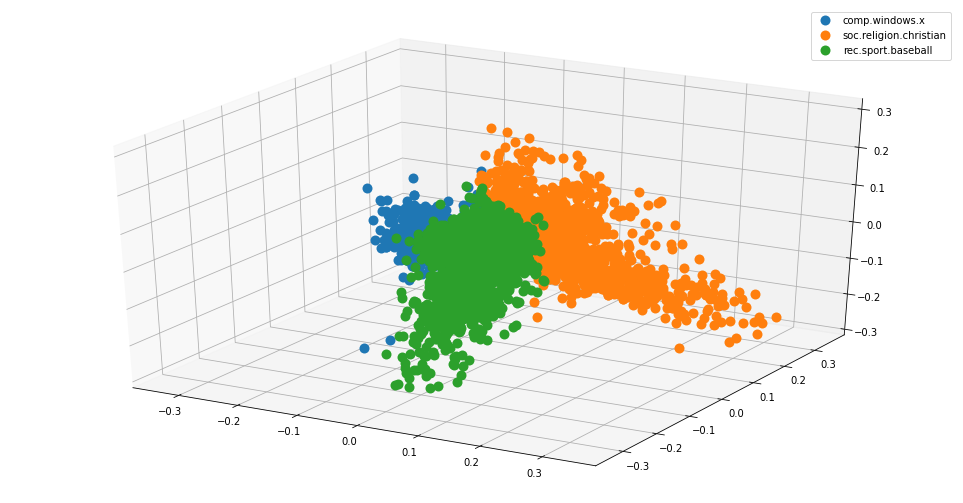

Complete Linkage Distance 0.21013989454032697
Average Linkage Distance 0.16846772923809583
Single Linkage Distance 0.14624113740562011


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (6)


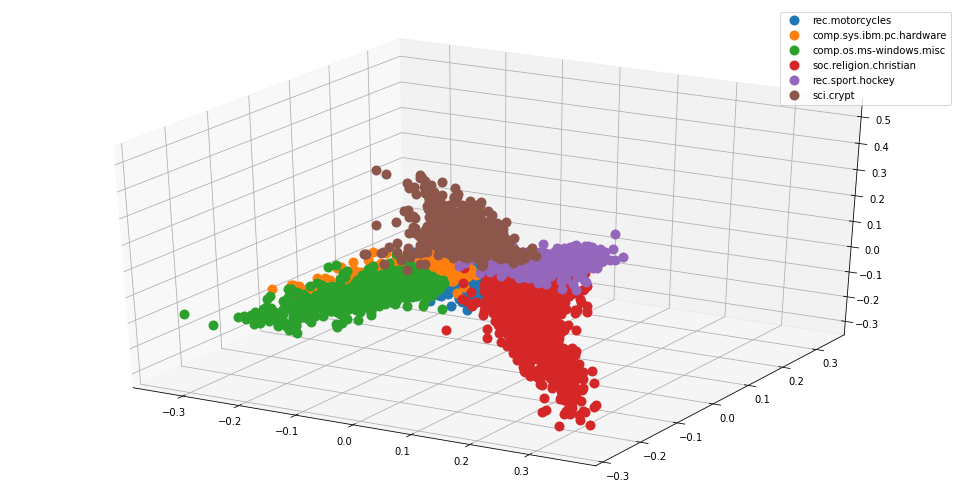

Cluster Type Test & clusters (6)


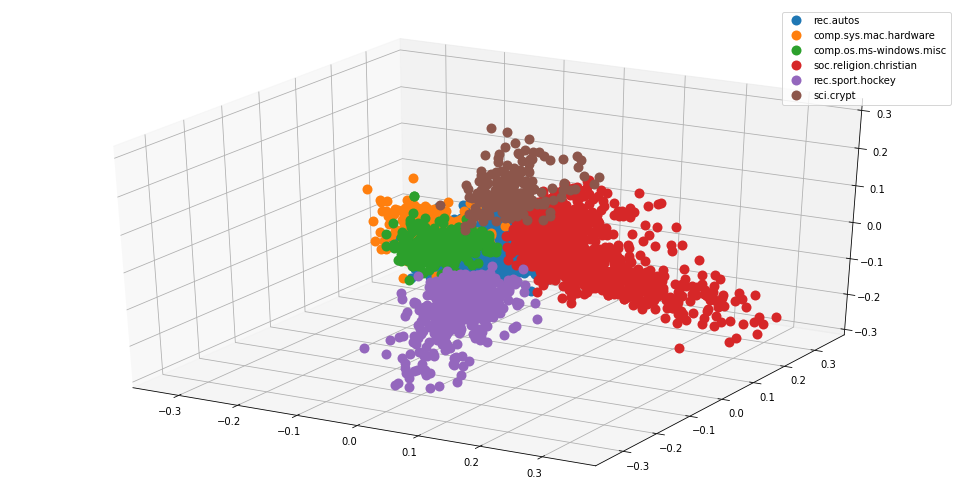

Complete Linkage Distance 0.35250522102410403
Average Linkage Distance 0.26208697472832
Single Linkage Distance 0.16074898531918627


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (12)


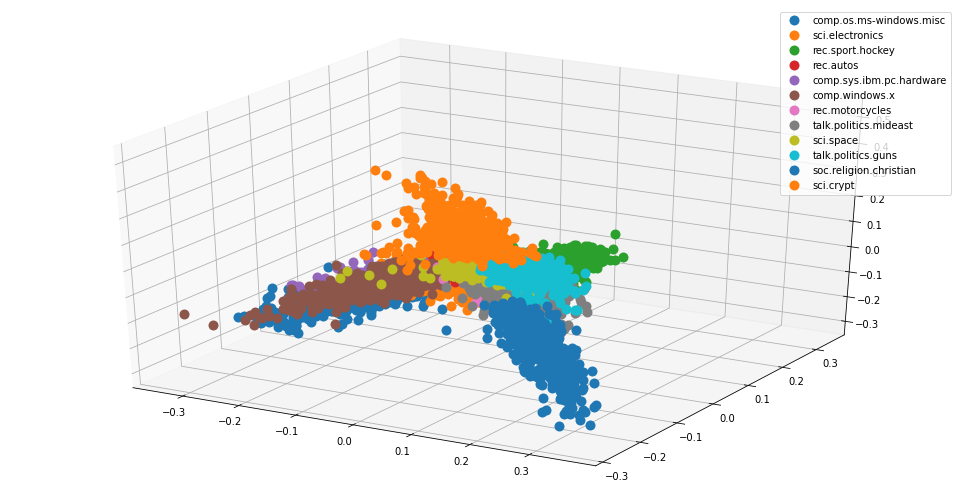

Cluster Type Test & clusters (12)


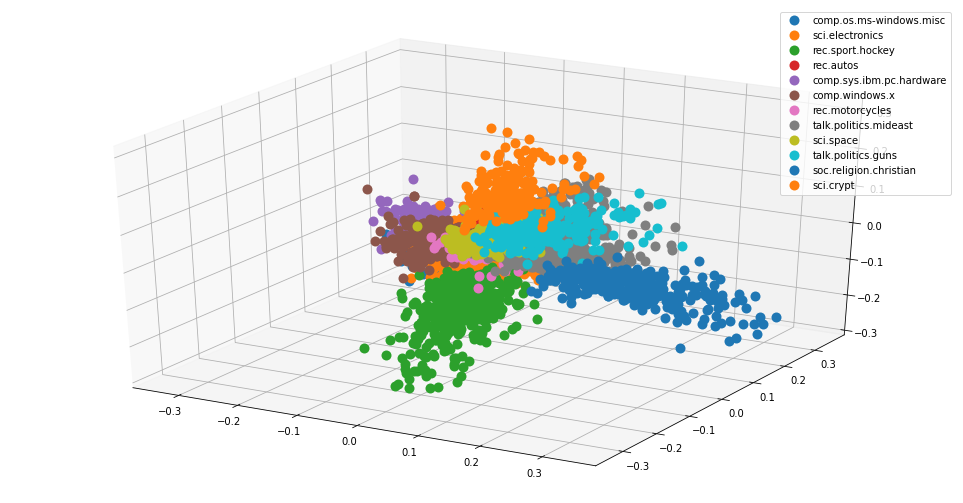

Complete Linkage Distance 0.4350532364359254
Average Linkage Distance 0.3063057740789837
Single Linkage Distance 0.15121737876036123


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (20)


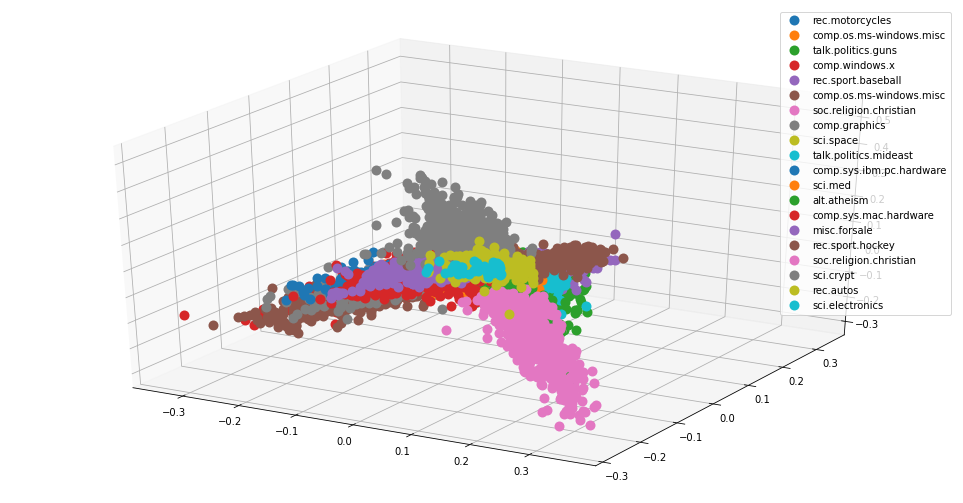

Cluster Type Test & clusters (20)


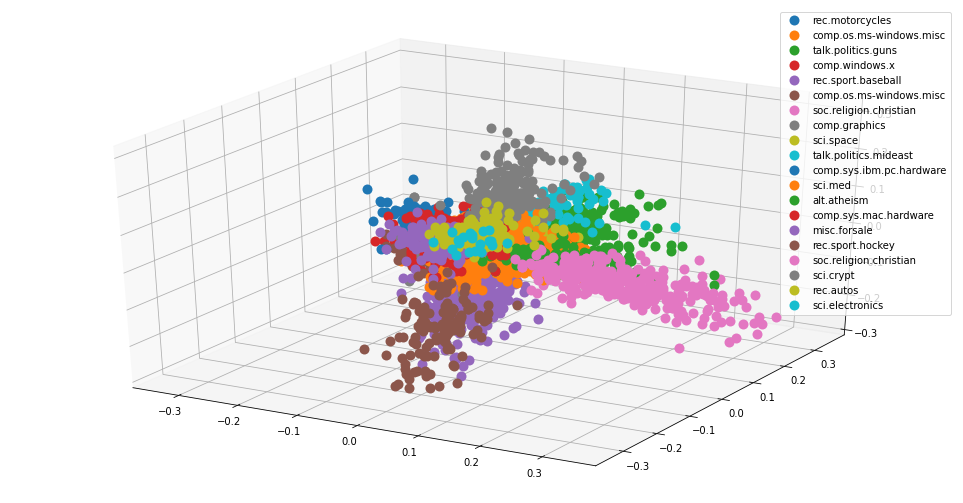

Complete Linkage Distance 0.671121801132574
Average Linkage Distance 0.37731809655964316
Single Linkage Distance 0.12696174189830725


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (3)


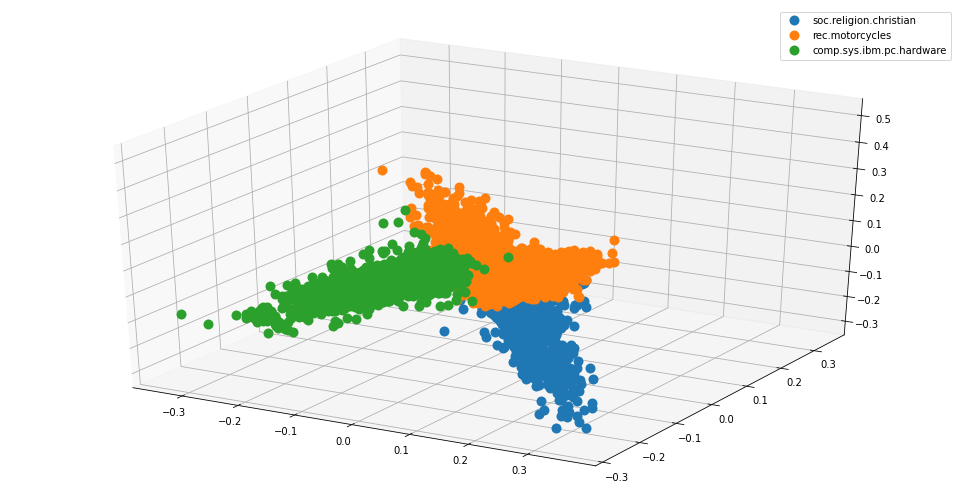

Cluster Type Test & clusters (3)


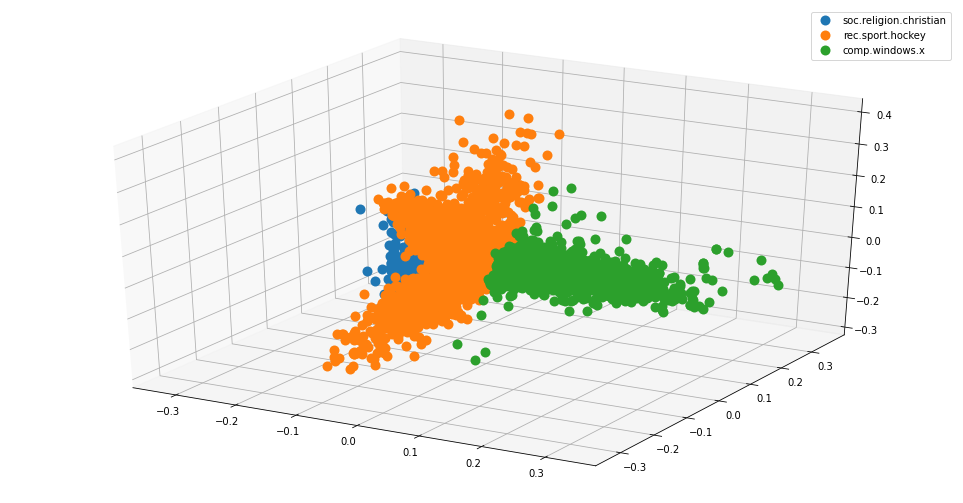

Complete Linkage Distance 0.25896327512165823
Average Linkage Distance 0.2025953735168485
Single Linkage Distance 0.13928933576661565


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (6)


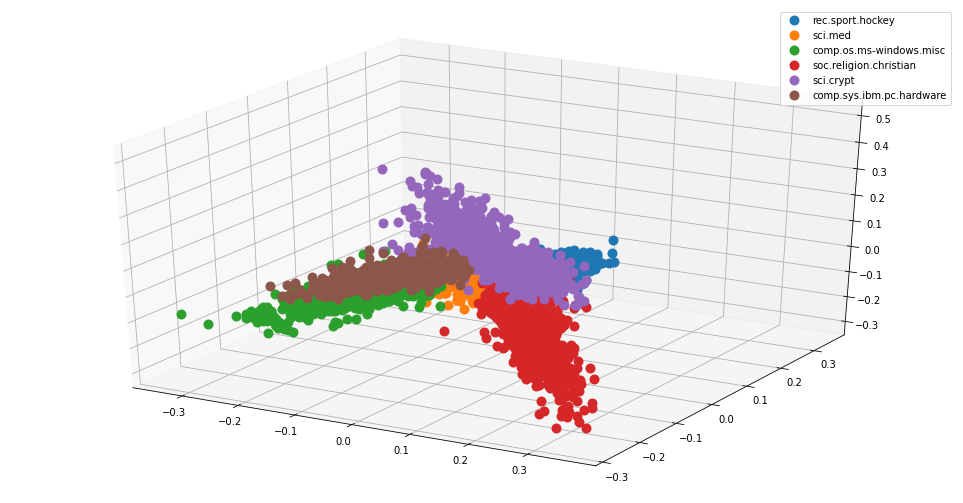

Cluster Type Test & clusters (6)


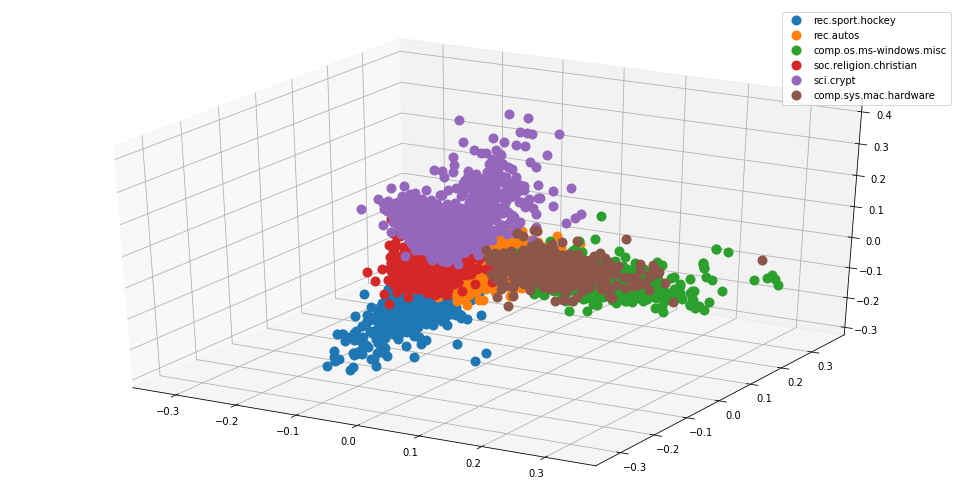

Complete Linkage Distance 0.2896994249995828
Average Linkage Distance 0.23682373284187447
Single Linkage Distance 0.16534639531460818


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (12)


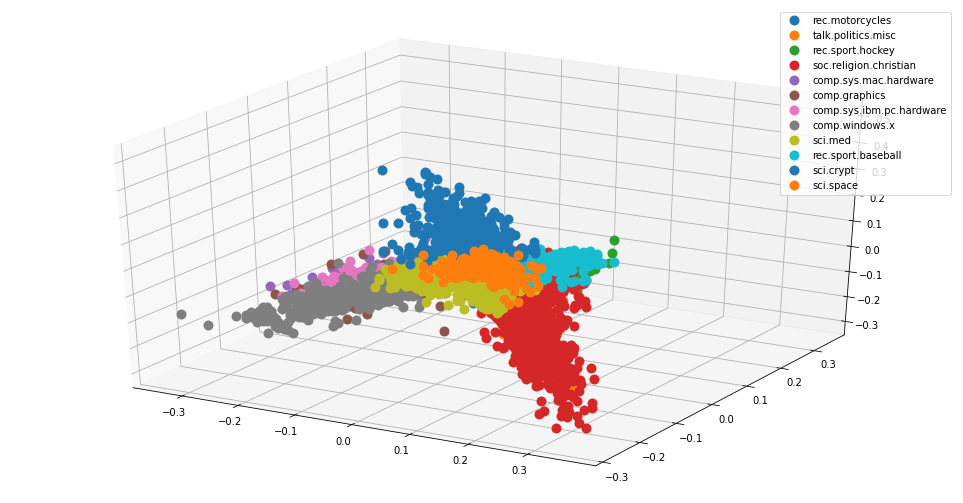

Cluster Type Test & clusters (12)


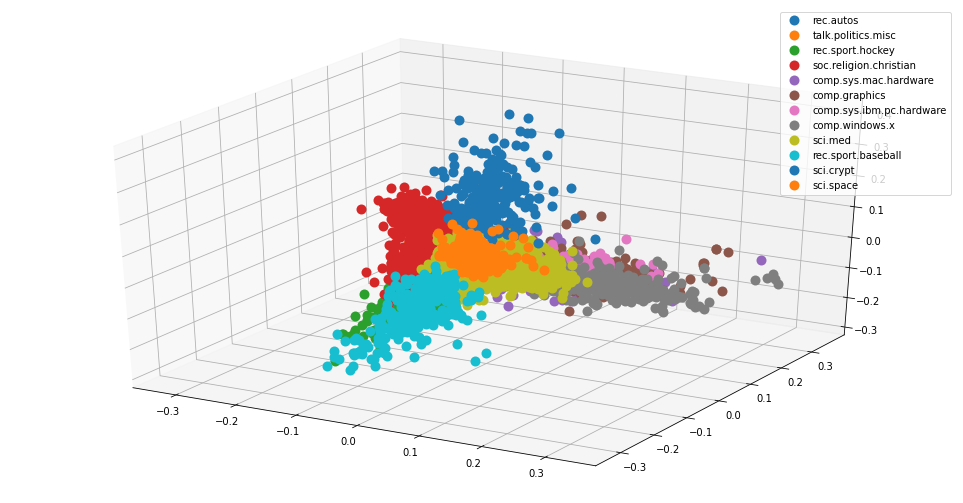

Complete Linkage Distance 0.442514674286046
Average Linkage Distance 0.30208809715980584
Single Linkage Distance 0.16144449786812154


/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Cluster Type Train & clusters (20)


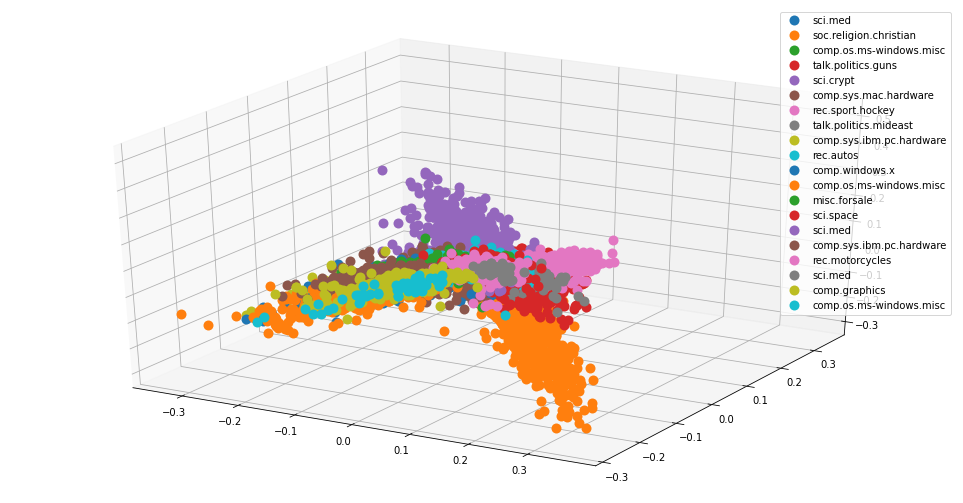

Cluster Type Test & clusters (20)


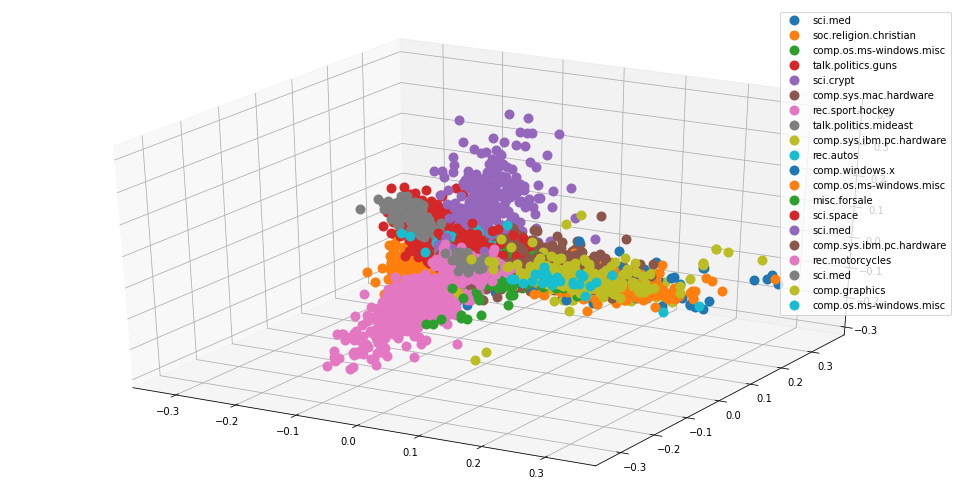

Complete Linkage Distance 0.8240019887882759
Average Linkage Distance 0.429171478584059
Single Linkage Distance 0.11965469990898427


In [10]:
KMeans_cluster(X_train_80, X_test_20, y_train_80, y_test_20,3,dataset)
KMeans_cluster(X_train_80, X_test_20, y_train_80, y_test_20,6,dataset)
KMeans_cluster(X_train_80, X_test_20, y_train_80, y_test_20,12,dataset)
KMeans_cluster(X_train_80, X_test_20, y_train_80, y_test_20,20,dataset)

KMeans_cluster(X_train_70, X_test_30, y_train_70, y_test_30,3,dataset)
KMeans_cluster(X_train_70, X_test_30, y_train_70, y_test_30,6,dataset)
KMeans_cluster(X_train_70, X_test_30, y_train_70, y_test_30,12,dataset)
KMeans_cluster(X_train_70, X_test_30, y_train_70, y_test_30,20,dataset)

KMeans_cluster(X_train_60, X_test_40, y_train_60, y_test_40,3,dataset)
KMeans_cluster(X_train_60, X_test_40, y_train_60, y_test_40,6,dataset)
KMeans_cluster(X_train_60, X_test_40, y_train_60, y_test_40,12,dataset)
KMeans_cluster(X_train_60, X_test_40, y_train_60, y_test_40,20,dataset)